In [1]:
import tifffile

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
messy = tifffile.imread('/mnt/HD-LSDF/Xenopus/2021_11_Xenopus/Vergleichsmessungen_NN/Xenopus_16_3p125_ms_exp_750_proj/radios_corrected/1.tif')

In [4]:
messy.shape

(223, 2016, 2016)

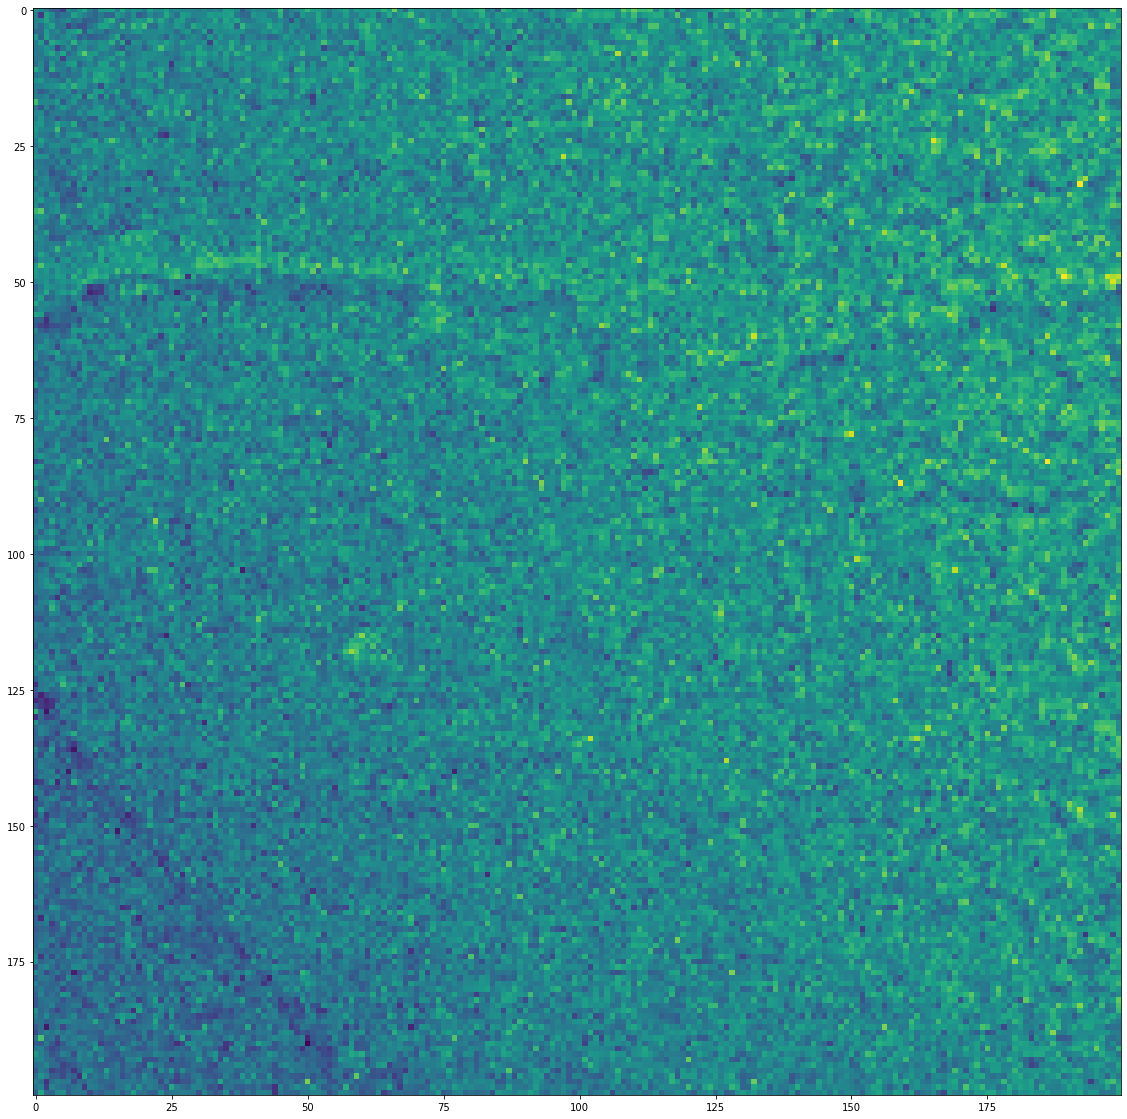

In [5]:
plt.figure(figsize=(20, 20))
plt.imshow(messy[0][1200:1400, 600:800])
plt.show()

In [6]:
from copy import deepcopy
import numpy as np
from skimage.filters import rank
from scipy.signal import convolve2d

footprint = np.array([[0, 1, 0], 
                      [1, 0, 1], 
                      [0, 1 ,0]])

mask = footprint / footprint.sum()

def get_two_views(one_slice):
    first_sample = deepcopy(one_slice)
    second_sample = deepcopy(one_slice)
    
    x,y = np.meshgrid(*[np.arange(i) for i in first_sample.shape])
    first_sample[(x + y)%2 == 0] = 0
    second_sample[(x + y)%2 == 1] = 0
    
    
    filtered_first = convolve2d(first_sample, mask, mode='same')
    first_sample[(x + y)%2 == 0] = filtered_first[(x + y)%2 == 0]

    filtered_second = convolve2d(second_sample, mask, mode='same')
    second_sample[(x + y)%2 == 1] = filtered_second[(x + y)%2 == 1]
    
    return first_sample, second_sample

In [7]:
f,s = get_two_views(messy[0])

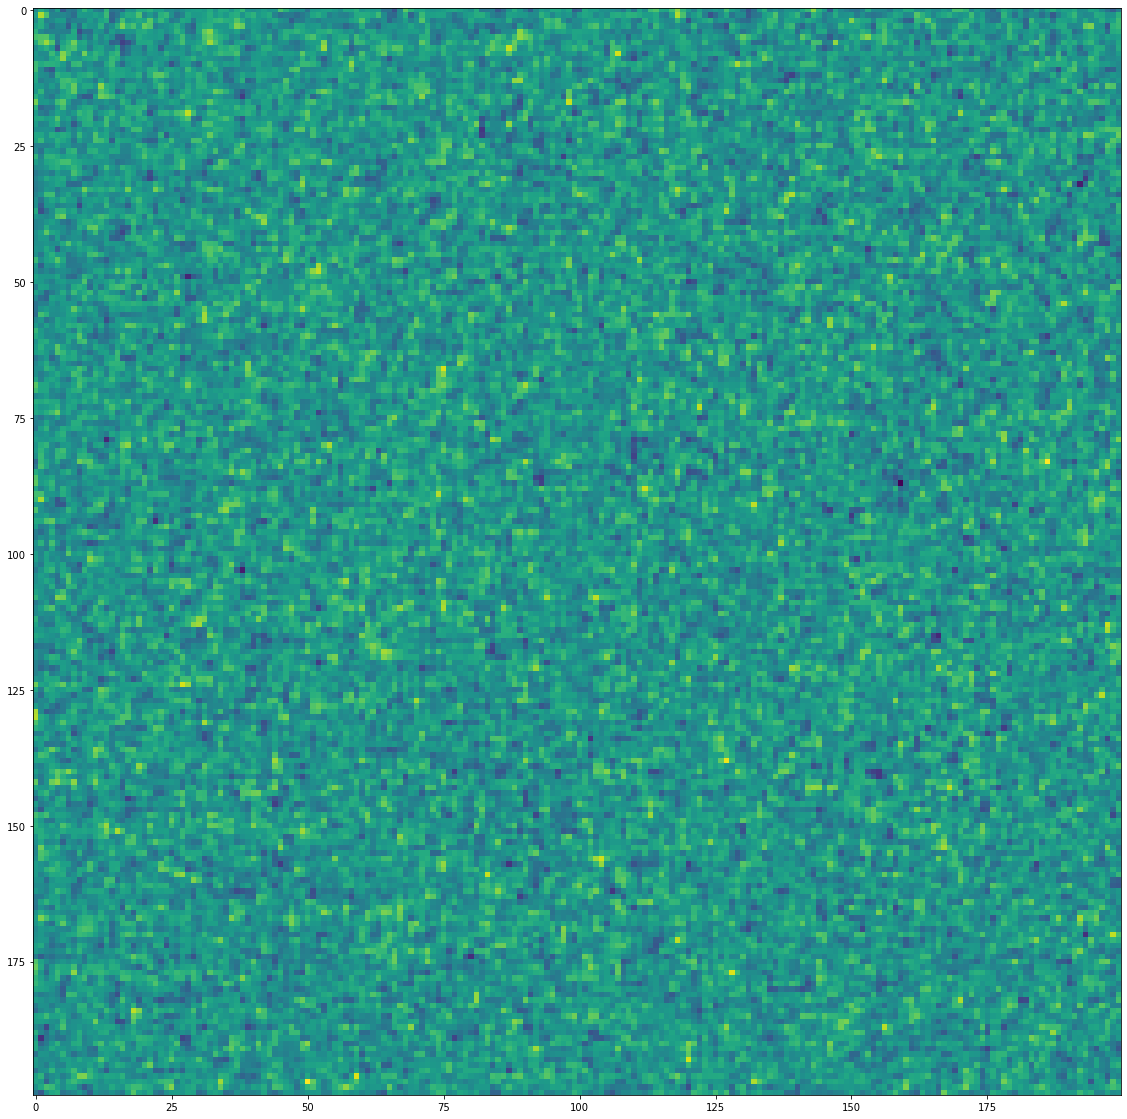

In [8]:
plt.figure(figsize=(20, 20))
plt.imshow((f-s)[1200:1400, 600:800])
plt.show()

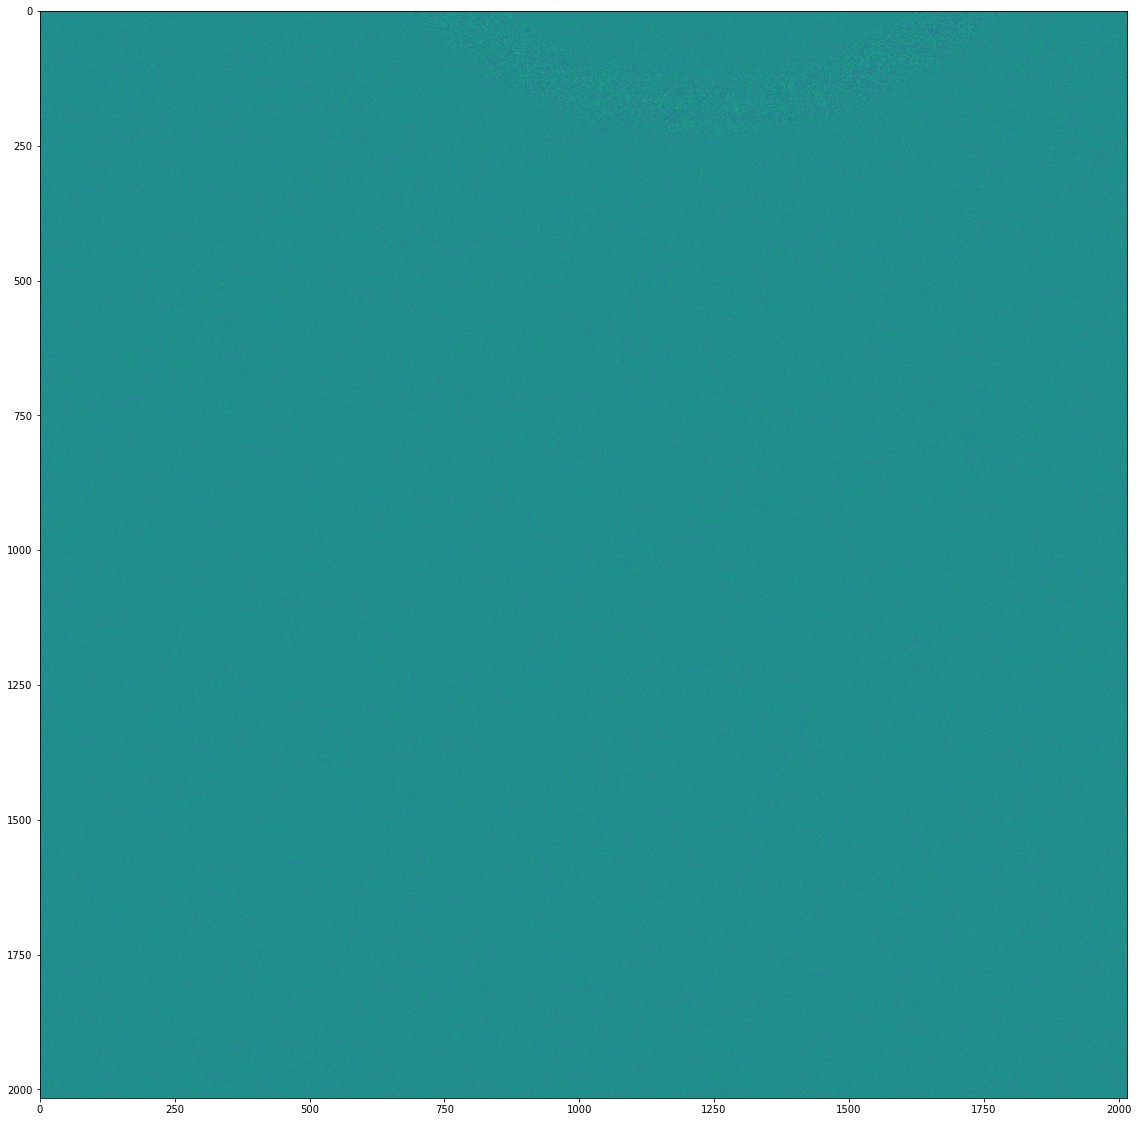

In [9]:
plt.figure(figsize=(20, 20))
plt.imshow((f-s))
plt.show()

In [10]:
from skimage.morphology import disk

/tmp/ipykernel_3615053/3952034354.py:2: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  plt.imshow(rank.entropy((f-s), footprint=disk(5)))


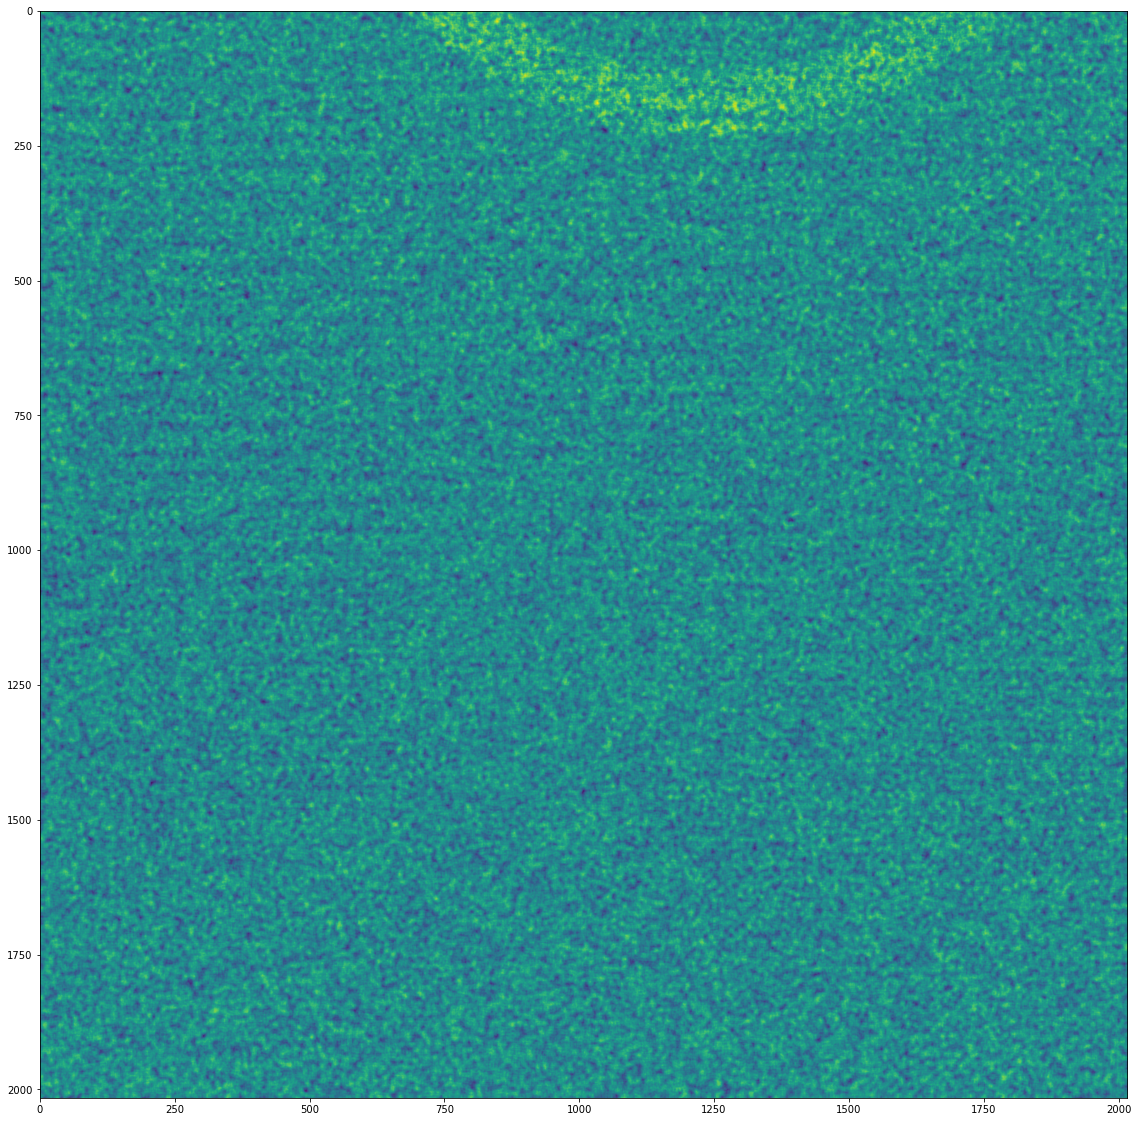

In [11]:
plt.figure(figsize=(20, 20))
plt.imshow(rank.entropy((f-s), footprint=disk(5)))
plt.show()

In [12]:
from glob import glob
from tqdm.auto import tqdm

In [13]:
all_baddies = glob('/mnt/HD-LSDF/Xenopus/2021_11_Xenopus/Vergleichsmessungen_NN/Xenopus_*_3p125_ms_exp_750_proj/radios_corrected')

In [14]:
all_baddies

['/mnt/HD-LSDF/Xenopus/2021_11_Xenopus/Vergleichsmessungen_NN/Xenopus_13_3p125_ms_exp_750_proj/radios_corrected',
 '/mnt/HD-LSDF/Xenopus/2021_11_Xenopus/Vergleichsmessungen_NN/Xenopus_16_3p125_ms_exp_750_proj/radios_corrected',
 '/mnt/HD-LSDF/Xenopus/2021_11_Xenopus/Vergleichsmessungen_NN/Xenopus_14_3p125_ms_exp_750_proj/radios_corrected',
 '/mnt/HD-LSDF/Xenopus/2021_11_Xenopus/Vergleichsmessungen_NN/Xenopus_15_3p125_ms_exp_750_proj/radios_corrected']

In [15]:
projs_volumes = []
for messy_xenopus_addr in tqdm(all_baddies):
    tmp_volumes = []
    for con_id in [0, 1]:
        tmp_volumes.append(tifffile.imread(messy_xenopus_addr+f'/{con_id}.tif'))
    projs_volumes.append(np.concatenate(tmp_volumes, 0))

  0%|          | 0/4 [00:00<?, ?it/s]

To the test we move the xenopus #15

In [17]:
train_volumes = projs_volumes[:-1]
valid_volumes = projs_volumes[-1:]

In [18]:
from joblib import Parallel, delayed

In [19]:
train_a, train_b = [], []
for vol in tqdm(train_volumes):
    pairs = Parallel(n_jobs=64)(delayed(get_two_views)(slc) for slc in vol)
    for a,b in pairs:
        train_a += [a, b]
        train_b += [b, a]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
%%time
train_a = np.stack(train_a, axis=0)
train_b = np.stack(train_b, axis=0)

In [ ]:
valid_a, valid_b = [], []
for vol in tqdm(valid_volumes):
    pairs = Parallel(n_jobs=64)(delayed(get_two_views)(slc) for slc in vol)
    for a,b in pairs:
        valid_a += [a, b]
        valid_b += [b, a]

In [ ]:
%%time
valid_a = np.stack(valid_a, axis=0)
valid_b = np.stack(valid_b, axis=0)

In [21]:
def get_random_voxels(img, count):
    return img[tuple([np.random.randint(0, img.shape[i], count) for i in range(img.ndim)])]

CHUNK_SIZE = 256
import dask.array as da
from skimage.exposure import rescale_intensity
from functools import partial

def scale_intensity_parallel(img, in_percentiles=(0.1, 99.9), out_range=(-1, 1)):
    rs = get_random_voxels(img, 1_000_000)
    f = np.percentile(rs, in_percentiles[0])
    t = np.percentile(rs, in_percentiles[1])
    
    img = da.from_array(img, chunks=CHUNK_SIZE)
    scaler = partial(rescale_intensity, in_range=(f,t), out_range=out_range)
    img = img.map_blocks(scaler, dtype=img.dtype)
    img = np.array(img, dtype=img.dtype)

    return img

In [22]:
def get_scaled_volume(v):
    v_f = v.astype(np.float32)
    return scale_intensity_parallel(v_f)

In [ ]:
import os

In [ ]:
%%time
tifffile.imwrite('/mnt/data/denoising/xeno/corr/train/volumes/1.tif', get_scaled_volume(train_a))
tifffile.imwrite('/mnt/data/denoising/xeno/corr/train/labels/1.tif', get_scaled_volume(train_b))
tifffile.imwrite('/mnt/data/denoising/xeno/corr/valid/volumes/1.tif', get_scaled_volume(valid_a))
tifffile.imwrite('/mnt/data/denoising/xeno/corr/valid/labels/1.tif', get_scaled_volume(valid_b))

In [ ]:
plt.imshow(train_a[0]);

In [ ]:
plt.imshow(train_b[0]);

In [ ]:
np.abs((train_a-train_b)).mean()

In [2]:
a = tifffile.imread('/mnt/data/denoising/xeno/32bit/train/volumes/1.tif')
b = tifffile.imread('/mnt/data/denoising/xeno/32bit/train/labels/1.tif')

In [5]:
np.abs((a-b)).mean()

0.044173226

In [6]:
a = tifffile.imread('/mnt/data/denoising/xeno/32bit/valid/volumes/1.tif')
b = tifffile.imread('/mnt/data/denoising/xeno/32bit/valid/labels/1.tif')

In [7]:
np.abs((a-b)).mean()

0.042861402

In [17]:
import os

In [18]:
os.makedirs('/mnt/data/denoising/xeno/corr/all_volumes', exist_ok=True)
os.makedirs('/mnt/data/denoising/xeno/corr/all_volumes_processed', exist_ok=True)

In [23]:
for v,a in tqdm(zip(projs_volumes, all_baddies)):
    n = os.path.split(os.path.split(a)[0])[1]
    tifffile.imwrite(f'/mnt/data/denoising/xeno/corr/all_volumes/{n}.tif', get_scaled_volume(v))

0it [00:00, ?it/s]